In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal, series_factor_model_covariance
from cvx_portfolio.risks import EmpSigma, FactorModelSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])
del volumes['USDOLLAR']
del sigmas['USDOLLAR']
spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)

In [3]:
np.random.seed(1)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')
alpha_signal.USDOLLAR = returns.USDOLLAR
alpha_model = AlphaSource(alpha_signal)

/home/enzo/repos/cvx_portfolio/cvx_portfolio/data/generator.py:30: RuntimeWarning: overflow encountered in exp
  sig*ex*np.concatenate([[0],np.cumsum(np.sqrt(np.diff(np.exp(2*th*t)-1))*np.random.randn(len(t)-1))])
/home/enzo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:1578: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


In [4]:
# corrcoeffs=pd.Series(index=returns.columns,
#           data=map(lambda ticker: np.corrcoef(alpha_signal[ticker], returns[ticker])[0,1], returns.columns)).ix[:-1]
# corrcoeffs.plot()
# corrcoeffs.mean(), corrcoeffs.median()

In [5]:
# alpha_signal.mean().plot()
# returns.mean().plot()

In [6]:
# alpha_signal.std().plot()
# returns.std().plot()

### Simulations

In [7]:
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.6,
                                                                           freq='MS',lookback_periods = 12)
risk_model = FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)
#risk_model = EmpSigma(returns, lookback=500)

p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)
p_0 = 1E8*p

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

policies={}
gamma_risks=[0., .5, 10., 100., 1000.,]
gamma_tcosts=[0., 1., 50., 60., 70., 80., 90.] # only 0 1 60 70
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
                SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost], 
                                [LeverageLimit(3)])

## Simulations

In [8]:
results=dict(zip(policies.keys(), 
                 simulator.run_multiple_backtest(p_0, start_time="2012-01-01",end_time="2016-12-31",
                                              policies=policies.values(), parallel=True)))

In [9]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

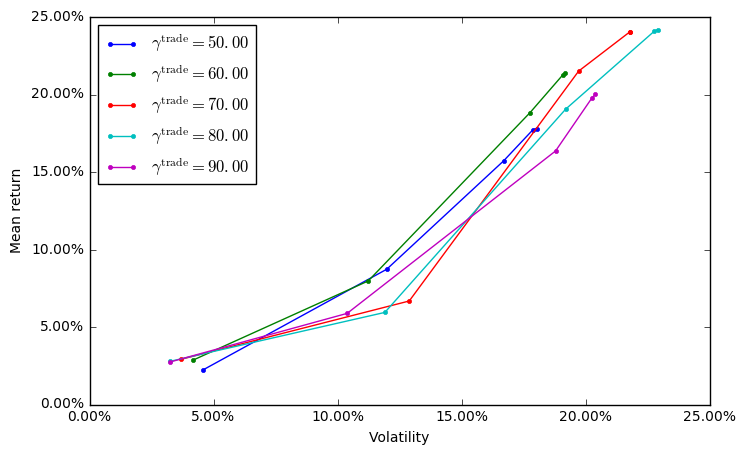

In [101]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns[2:]:
    #plt.figure()
    x = [100*result_df.loc[(i, gamma_tcost)].volatility for i in result_df.index]
    y = [100*result_df.loc[(i, gamma_tcost)].mean_return for i in result_df.index]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Volatility')
plt.ylabel('Mean return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

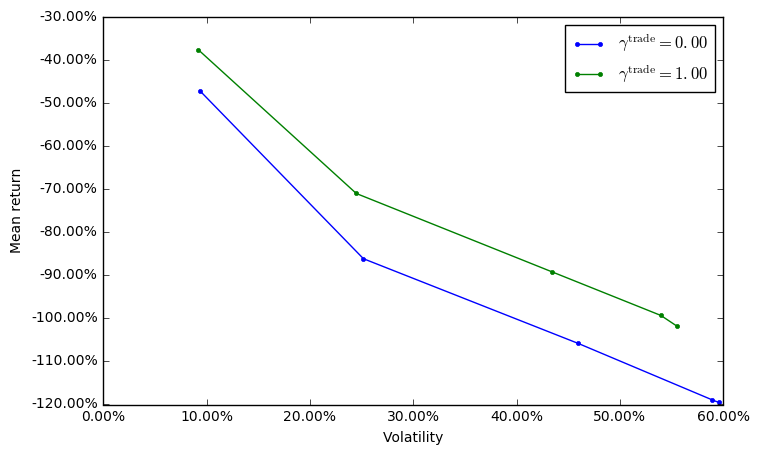

In [102]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns[:2]:
    #plt.figure()
    x = [100*result_df.loc[(i, gamma_tcost)].volatility for i in result_df.index]
    y = [100*result_df.loc[(i, gamma_tcost)].mean_return for i in result_df.index]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper right')
plt.xlabel('Volatility')
plt.ylabel('Mean return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier_bad.png')

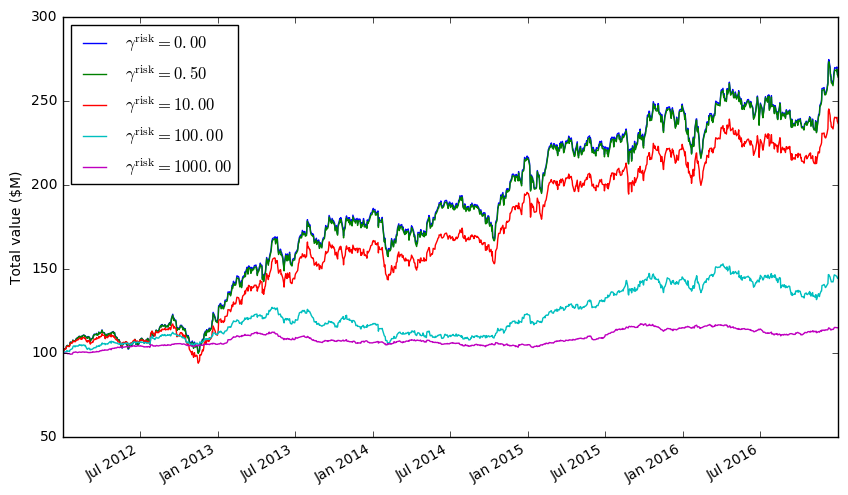

In [107]:
gamma_tcost=60.
plt.figure(figsize=(10,6))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %.2f$'%i) for i in gamma_risks]
plt.legend(loc='upper right' if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [114]:
result_df_used= result_df[[0.,1.,50.,60.,70.]]

avg_daily_return=lambda res: "%.2f%%"%(res.mean_return*100)
avg_annual_tcost=lambda res: "%.2f%%"%((res.simulator_TcostModel.sum(1)/res.v).mean() *250*100)
volatility=lambda x: "%.2f%%"%(x.returns.std()*100)
#time=lambda x: x.simulation_time.mean() + x.policy_time.mean()
#risk=lambda x: np.mean(np.sqrt(x.policy_FactorModelSigma))*10000
#growth_rate=lambda x: np.mean(np.log(1+x.returns))*10000


table=pd.Panel({r'$\bar {R^\mathrm{p}}$':result_df_used.applymap(avg_daily_return),
          r'Annual t. cost':result_df_used.applymap(avg_annual_tcost),
          r'$\sigma^\mathrm{p}$':result_df_used.applymap(volatility),
        # r'$SR$':result_df.applymap(lambda x: x.sharpe_ratio),
          #      r'$\displaystyle\frac{\sum_t \sqrt{\psi_t (w_t + z_t)}}{T}$':result_df.applymap(risk),
         #       r'$\displaystyle\frac{\sum_t \log (1 + R^\text{p}_t)}{T}$':result_df.applymap(growth_rate),
         #'run time (s.)':result_df.applymap(time)
               }).to_frame()
table = table.set_index(table.index.rename([r'$\gamma^\mathrm{risk}$', r'$\gamma^\mathrm{trade}$']))


# reorder
#cols = table.columns
#newcols = [cols[0]] + [cols[1]] + [cols[-1]] + [cols[2]] + [cols[3]] + [cols[4]]
#table = table[newcols]

# format values
#table = table.applymap(lambda x: '%.2f'%x)
#table.ix[:,-1]=table.ix[:,-1].apply(lambda x: x[:-3])
#table.ix[:,2]=table.ix[:,2].apply(lambda x: x[:-3])

# format index
table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
                      ["%d"%i for i in table.index.levels[1]]]))

# highlighting
# def highlight_cell(level, column):
#     max_arg = np.argmax(table.loc[level].ix[:,column].apply(np.float))
#     table.loc[level].ix[max_arg,column] = "\cellcolor{lightgray}%s"%table.loc[level].ix[max_arg,column]
# for gamma_risk in table.index.levels[0]:
#     highlight_cell(gamma_risk, 0)
#     highlight_cell(gamma_risk, 3)

table

$\bar {R^\mathrm{p}}$  \
$\gamma^\mathrm{risk}$ $\gamma^\mathrm{trade}$                         
0                      0                                    -119.53%   
                       1                                    -101.86%   
                       50                                     17.79%   
                       60                                     21.40%   
                       70                                     24.06%   
0.5                    0                                    -118.94%   
                       1                                     -99.32%   
                       50                                     17.73%   
                       60                                     21.28%   
                       70                                     24.03%   
10                     0                                    -105.82%   
                       1                                     -89.17%   
                       50                                     15.72%   
                       60                                     18.83%   
                       70                                     21.51%   
100                    0                                     -86.14%   
                       1                                     -70.99%   
                       50                                      8.73%   
                       60                                      7.97%   
                       70                                      6.68%   
1000                   0                                     -47.13%   
                       1                                     -37.59%   
                       50                                      2.22%   
                       60                                      2.87%   
                       70                                      2.91%   

                                               $\sigma^\mathrm{p}$  \
$\gamma^\mathrm{risk}$ $\gamma^\mathrm{trade}$                       
0                      0                                     3.75%   
                       1                                     3.50%   
                       50                                    1.14%   
                       60                                    1.21%   
                       70                                    1.37%   
0.5                    0                                     3.71%   
                       1                                     3.40%   
                       50                                    1.13%   
                       60                                    1.20%   
                       70                                    1.37%   
10                     0                                     2.90%   
                       1                                     2.74%   
                       50                                    1.05%   
                       60                                    1.12%   
                       70                                    1.24%   
100                    0                                     1.59%   
                       1                                     1.54%   
                       50                                    0.76%   
                       60                                    0.71%   
                       70                                    0.81%   
1000                   0                                     0.59%   
                       1                                     0.58%   
                       50                                    0.29%   
                       60                                    0.26%   
                       70                                    0.23%   

                                               Annual t. cost  
$\gamma^\mathrm{risk}$ $\gamma^\mathrm{trade}$                 
0                      0                              171.82%  
                   

In [116]:
print(table.to_latex(escape=False).replace('%','\%'))

\begin{tabular}{lllll}
\toprule
  &   & $\bar {R^\mathrm{p}}$ & $\sigma^\mathrm{p}$ & Annual t. cost \\
$\gamma^\mathrm{risk}$ & $\gamma^\mathrm{trade}$ &                       &                     &                \\
\midrule
0 & 0 &              -119.53\% &               3.75\% &        171.82\% \\
  & 1 &              -101.86\% &               3.50\% &        143.41\% \\
  & 50 &                17.79\% &               1.14\% &          1.14\% \\
  & 60 &                21.40\% &               1.21\% &          0.63\% \\
  & 70 &                24.06\% &               1.37\% &          0.42\% \\
0.5 & 0 &              -118.94\% &               3.71\% &        171.78\% \\
  & 1 &               -99.32\% &               3.40\% &        142.29\% \\
  & 50 &                17.73\% &               1.13\% &          1.13\% \\
  & 60 &                21.28\% &               1.20\% &          0.64\% \\
  & 70 &                24.03\% &               1.37\% &          0.42\% \\
10 & 0 &      

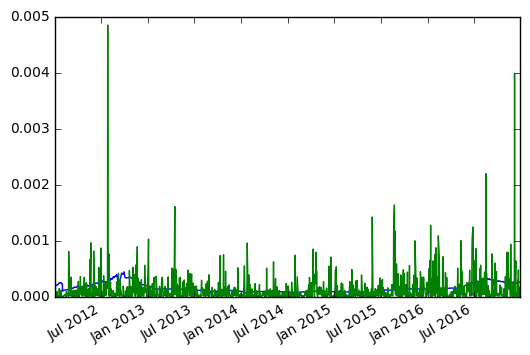

In [13]:
results[(.5,50)].policy_FactorModelSigma.plot()
(results[(.5,50)].returns**2).plot()

In [14]:
Z=result_df.applymap(lambda x: x.mean_return)
Y=result_df.applymap(lambda x: x.volatility)
X=result_df.applymap(lambda x: x.simulator_TcostModel.sum().sum()/1E8)

X, Y, Z = X.values, Y.values, Z.values


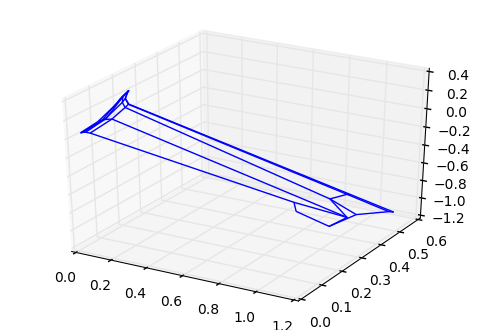

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
# ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=1, antialiased=True)
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)


plt.show()


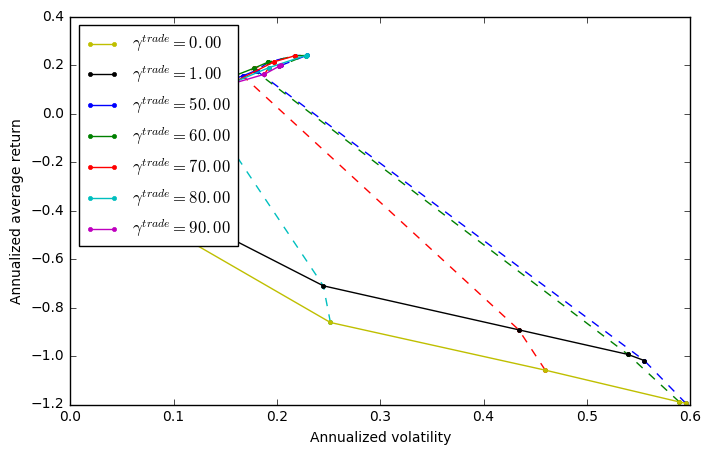

In [16]:
plt.figure(figsize=(8,5))
for i in result_df.index[:]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for gamma_tcost in result_df.columns]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for gamma_tcost in result_df.columns]
    plt.plot(np.array(x),np.array(y), '.--')
    
for gamma_tcost in result_df.columns[:]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in result_df.index]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in result_df.index]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
    
plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.savefig(plotdir+'spo_riskrewardfrontier.png')

In [17]:
# plt.figure(figsize=(8,5))
# for gamma_tcost in gamma_tcosts[1:]:
#     #plt.figure()
#     x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
#     y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
#     plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
# plt.legend(loc='upper left')
# plt.xlabel('Annualized volatility')
# plt.ylabel('Annualized average return')
# plt.savefig(plotdir+'spo_riskrewardfrontier.png')

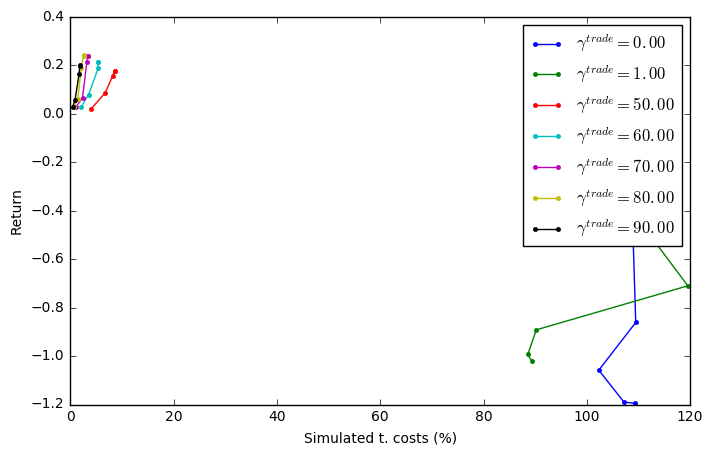

In [18]:
init_val = 100E6
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[:]:
    #plt.figure()
    x = [100*result_df.loc[(i, gamma_tcost)].simulator_TcostModel.sum().sum()/init_val for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper right')
plt.xlabel("Simulated t. costs (%)")
plt.ylabel("Return")
plt.savefig(plotdir+'spo_profittcost.png')

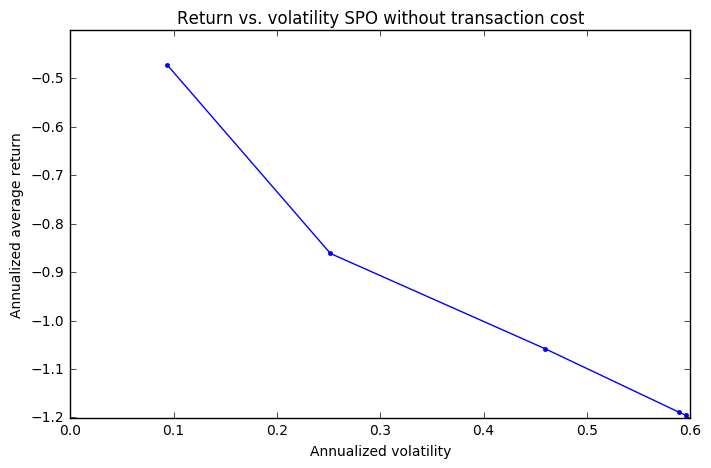

In [19]:
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts[:1]:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
#plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.title('Return vs. volatility SPO without transaction cost')
plt.savefig(plotdir+'spo_zerotcost_riskrewardfrontier.png')

In [20]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,0.0,1.0,50.0,60.0,70.0,80.0,90.0
gamma_risk,,,,,,,
0.0,-2.008085,-1.835391,0.980770,1.110670,1.098954,1.051255,0.975546
0.5,-2.019677,-1.842466,0.985395,1.108829,1.098333,1.052754,0.970148
10.0,-2.304343,-2.056753,0.934893,1.053769,1.085000,0.986736,0.864572
100.0,-3.425563,-2.903174,0.718965,0.699583,0.509510,0.489686,0.555371
1000.0,-5.052848,-4.101610,0.462055,0.659753,0.760226,0.822592,0.809901


In [21]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,0.0,1.0,50.0,60.0,70.0,80.0,90.0
gamma_risk,,,,,,,
0.0,0.073507,0.148697,0.168704,0.161357,0.168775,0.160204,0.155348
0.5,0.093632,0.180034,0.184208,0.168911,0.183934,0.195501,0.182454
10.0,0.096597,0.183670,0.197570,0.186109,0.211279,0.179643,0.186387
100.0,0.096654,0.160770,0.201794,0.206902,0.210472,0.170605,0.197221
1000.0,0.105485,0.180037,0.093272,0.180488,0.177337,0.183631,0.191311


In [22]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,0.0,1.0,50.0,60.0,70.0,80.0,90.0
gamma_risk,,,,,,,
0.0,92.472261,187.060408,212.230217,202.987509,212.319159,201.537238,195.427829
0.5,117.788626,226.483291,231.733544,212.489993,231.388883,245.939801,229.527627
10.0,121.518407,231.057430,248.542729,234.125219,265.788806,225.990795,234.474290
100.0,121.590233,202.249136,253.856508,260.283211,264.773193,214.620628,248.104620
1000.0,132.699869,226.486334,117.336787,227.054160,223.090355,231.007385,240.669383


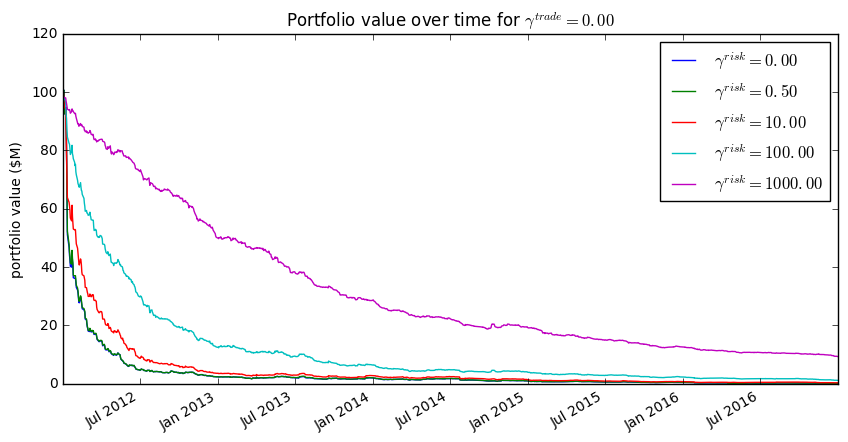

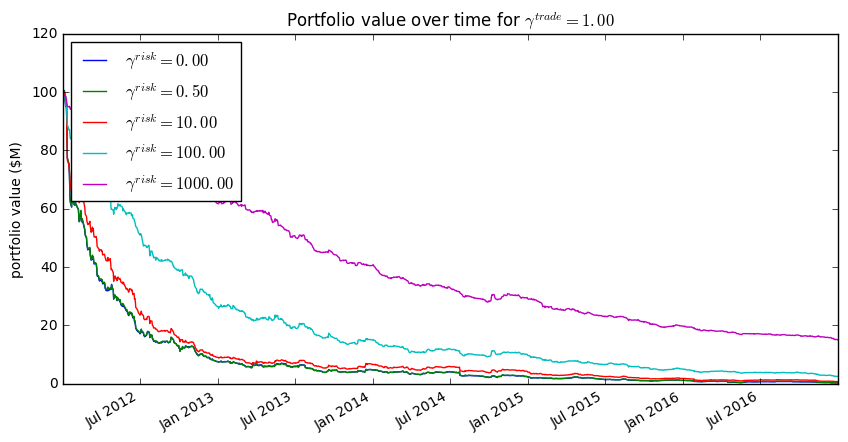

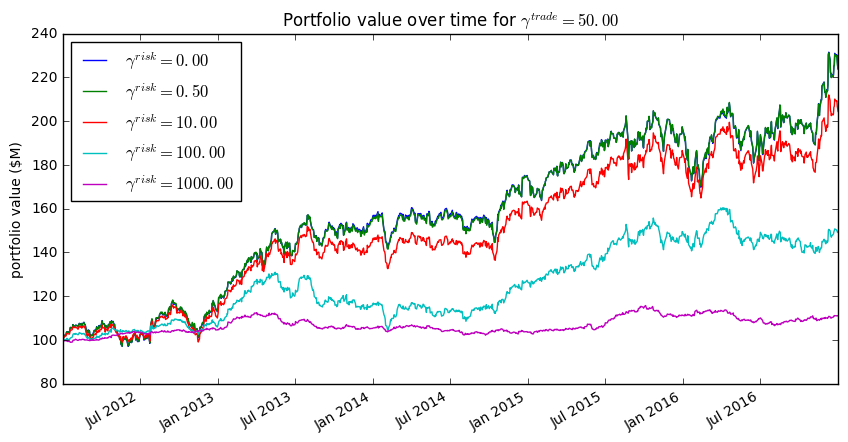

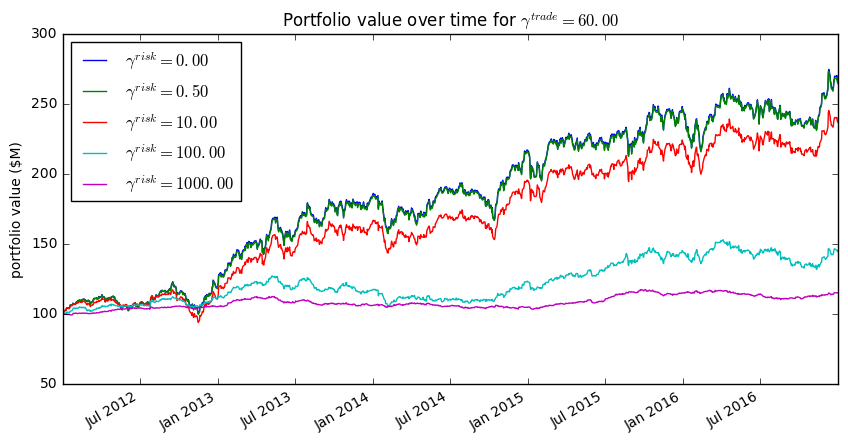

In [23]:
for i in range(4):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(10,5))
    [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper right' if i==0 else 'upper left')
    plt.ylabel('portfolio value (\$M)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

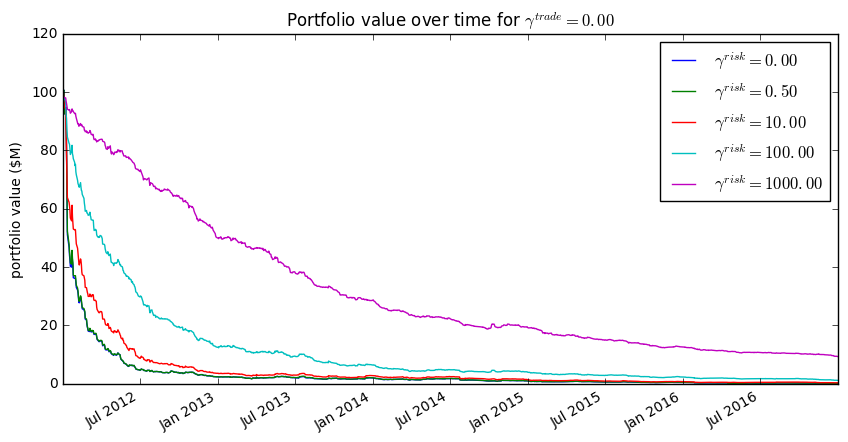

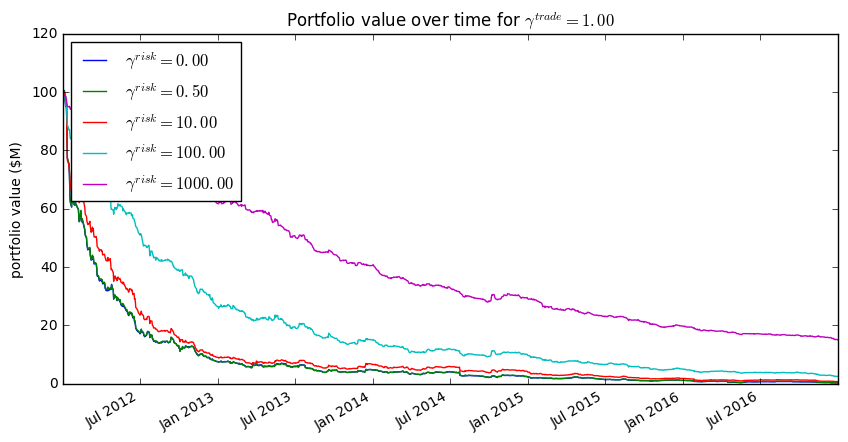

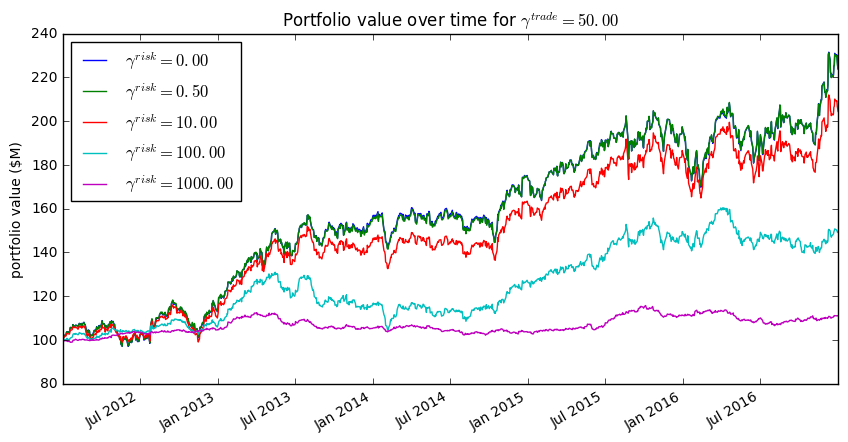

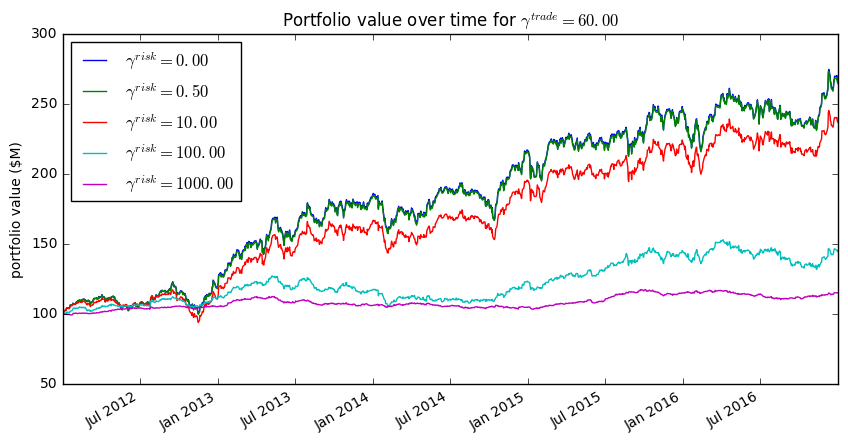

In [24]:
for i in range(4):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(10,5))
    [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper right' if i==0 else 'upper left')
    plt.ylabel('portfolio value (\$M)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

([0.0, 0.5, 10.0, 100.0, 1000.0], 90.0)

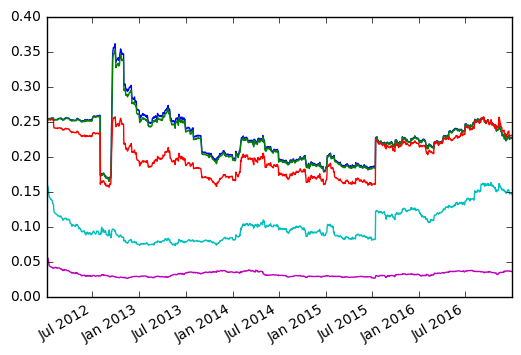

In [25]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

([0.0, 0.5, 10.0, 100.0, 1000.0], 50.0)

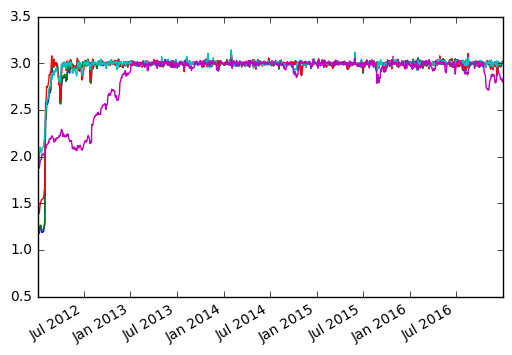

In [26]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.5, 10.0, 100.0, 1000.0], 1.0)

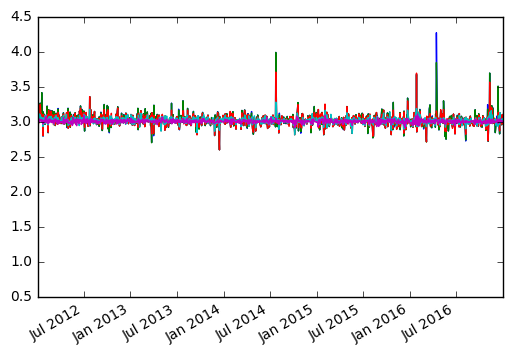

In [27]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([0.0, 0.5, 10.0, 100.0, 1000.0], 50.0)

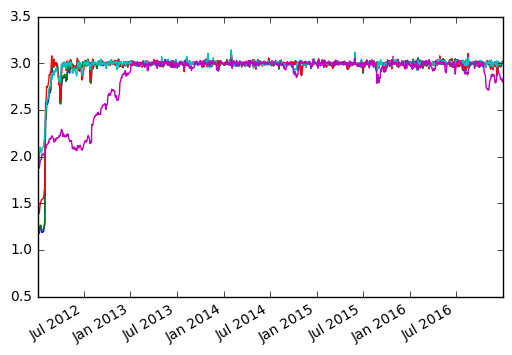

In [28]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.5, 10.0, 100.0, 1000.0], 50.0)

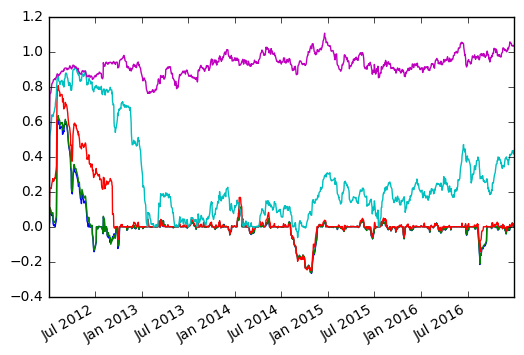

In [29]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.5, 10.0, 100.0, 1000.0], 50.0)

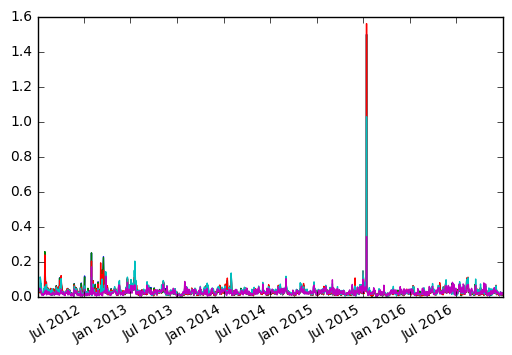

In [30]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [31]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

NameError: name 'res' is not defined

In [ ]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')